![](https://scikit-image.org/docs/dev/_static/img/logo.png)

# Stereo Feature Matching Using scikit-image

Kevin J. Walchko, Phd

12 Oct 2020

---

I primarily use OpenCV, but didn't realize how much `scikit-image` could do. This example is pretty much a direct copy of the example.

This example demonstrates how to robustly estimate epipolar geometry (the geometry of stereo vision) between two views using sparse ORB feature correspondences.

The fundamental matrix relates corresponding points between a pair of uncalibrated images. The matrix transforms homogeneous image points in one image to epipolar lines in the other image.

Uncalibrated means that the intrinsic calibration (focal lengths, pixel skew, principal point) of the two cameras is not known. The fundamental matrix thus enables projective 3D reconstruction of the captured scene. If the calibration is known, estimating the essential matrix enables metric 3D reconstruction of the captured scene.

## References

- [Fundamental matrix estimation](https://scikit-image.org/docs/dev/auto_examples/transform/plot_fundamental_matrix.html#sphx-glr-auto-examples-transform-plot-fundamental-matrix-py)
- [ORB feature detector and binary descriptor](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_orb.html#sphx-glr-auto-examples-features-detection-plot-orb-py)
- [3D Reconstructions From Multiple Images Using SFM](https://tianyusong.com/2017/12/05/3d-reconstructions-from-multiple-images-using-sfm/)
- github: [3D_Reconstruction_SFM](https://github.com/stytim/3D_Reconstruction_SFM)

In [1]:
import numpy as np
from skimage import data
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, ORB, plot_matches
from skimage.measure import ransac
from skimage.transform import FundamentalMatrixTransform
import matplotlib.pyplot as plt

In [4]:
np.random.seed(0)

In [5]:
img_left, img_right, groundtruth_disp = data.stereo_motorcycle()
img_left, img_right = map(rgb2gray, (img_left, img_right))

This example demonstrates the ORB feature detection and binary description algorithm. It uses an oriented FAST detection method and the rotated BRIEF descriptors.

Unlike BRIEF, ORB is comparatively scale and rotation invariant while still employing the very efficient Hamming distance metric for matching. As such, it is preferred for real-time applications.

In [6]:
# Find sparse feature correspondences between left and right image.

descriptor_extractor = ORB()

descriptor_extractor.detect_and_extract(img_left)
keypoints_left = descriptor_extractor.keypoints
descriptors_left = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img_right)
keypoints_right = descriptor_extractor.keypoints
descriptors_right = descriptor_extractor.descriptors

matches = match_descriptors(descriptors_left, descriptors_right,
                            cross_check=True)

# Estimate the epipolar geometry between the left and right image.

model, inliers = ransac((keypoints_left[matches[:, 0]],
                         keypoints_right[matches[:, 1]]),
                        FundamentalMatrixTransform, min_samples=8,
                        residual_threshold=1, max_trials=5000)

inlier_keypoints_left = keypoints_left[matches[inliers, 0]]
inlier_keypoints_right = keypoints_right[matches[inliers, 1]]

print(f"Number of matches: {matches.shape[0]}")
print(f"Number of inliers: {inliers.sum()}")

# Compare estimated sparse disparities to the dense ground-truth disparities.

disp = inlier_keypoints_left[:, 1] - inlier_keypoints_right[:, 1]
disp_coords = np.round(inlier_keypoints_left).astype(np.int64)
disp_idxs = np.ravel_multi_index(disp_coords.T, groundtruth_disp.shape)
disp_error = np.abs(groundtruth_disp.ravel()[disp_idxs] - disp)
disp_error = disp_error[np.isfinite(disp_error)]

Number of matches: 223
Number of inliers: 164


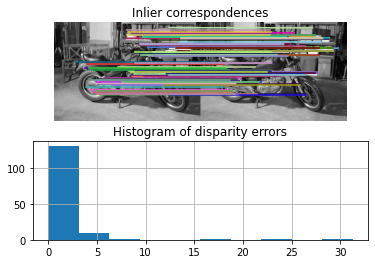

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=1)

# plt.gray()

plot_matches(ax[0], img_left, img_right, keypoints_left, keypoints_right,
             matches[inliers], only_matches=True)
ax[0].axis("off")
ax[0].set_title("Inlier correspondences")

ax[1].hist(disp_error)
ax[1].grid(True)
ax[1].set_title("Histogram of disparity errors");